In [ ]:
!pip install brainiak

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
#from brainiak.funcalign.srm import SRM
#from brainiak.isc import isc

In [10]:
roi = 'A1'
filepath = 'drive/MyDrive/fMRI_music_data/%s_by_subject_sorted_conds/'%roi
subjects = ['03','15','20','23']
n_sub = len(subjects)

In [7]:
# load data from one subject for a quick sanity check
this_subj = subjects[0]
test = np.load(filepath+'%s_sub-1%s.npy'%(roi,this_subj))
print(test.shape)

(516, 1776)


There are 516 voxels in A1. There are 1776 total time points: 148 TRs per run * 12 runs.

In [9]:
# load in the data from all subjects
data = []
for subj in subjects: 
  data.append(np.load(filepath+'%s_sub-1%s.npy'%(roi,this_subj)))

# recast the list into an array and check the shape
data = np.asarray(data)
print(data.shape)

(4, 516, 1776)


Reshape the data so that it's subjects x voxels x TRs x conds x runs. This gives flexibility to select training and testing data for SRM later.

In [ ]:
n_voxels = data.shape[1]
n_TRs = 148
n_conds = 4
n_runs = 3

orig_data = np.copy(data)
orig_data = np.reshape(orig_data,(n_sub,n_voxels,n_TRs*n_conds))

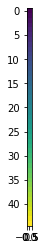

In [22]:
toy = np.arange(45)
toy = np.reshape(toy,(45,1))
plt.imshow(toy)

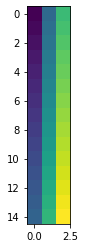

In [25]:
toy_re = np.reshape(toy,(15,3),order='F')
plt.imshow(toy_re)

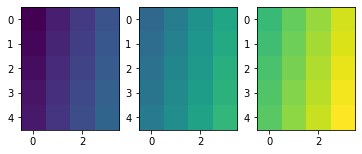

In [30]:
# this toy example has 5 TRs, 4 conditions, and 3 runs
toy = np.arange(60)
toy_re1 = np.reshape(toy, (5,4,3), order='F')

fig,ax = plt.subplots(1,3)
for i in range(3):
  ax[i].imshow(toy_re1[:,:,i], vmin=0,vmax=59)

In [31]:
print(toy_re1)

[[[ 0 20 40]
  [ 5 25 45]
  [10 30 50]
  [15 35 55]]

 [[ 1 21 41]
  [ 6 26 46]
  [11 31 51]
  [16 36 56]]

 [[ 2 22 42]
  [ 7 27 47]
  [12 32 52]
  [17 37 57]]

 [[ 3 23 43]
  [ 8 28 48]
  [13 33 53]
  [18 38 58]]

 [[ 4 24 44]
  [ 9 29 49]
  [14 34 54]
  [19 39 59]]]


In [33]:
print(toy_re1.shape)

(5, 4, 3)


This is confusing because the first dimension acts like z in the printed array.